# BBBC comparison

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scip_workflows.common import *

In [3]:

import pickle

In [4]:
try:
    path_gt = snakemake.input.gt
    moa_path = snakemake.input.moa
    image_path = snakemake.input.image
    path = snakemake.input.features
except NameError:
    data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021")
    # data_root = Path("/home/maximl/scratch/data/vsc/datasets/BBBC021/")
    data_dir_gt = data_root / "cellprofiler"
    path_gt = data_dir_gt / "db.sqlite3"
    moa_path = data_root / "BBBC021_v1_moa.csv"
    image_path = data_root / "BBBC021_v1_image.csv"
    data_dir = data_root / "results" / "images_subset_v4"
    path = data_dir / "features.parquet"

In [6]:
moa = pandas.read_csv(moa_path)
image = pandas.read_csv(image_path)

In [7]:
moa_image = moa.merge(
    image,
    left_on=["compound", "concentration"],
    right_on=["Image_Metadata_Compound", "Image_Metadata_Concentration"]
).drop(columns=["Image_Metadata_Compound", "Image_Metadata_Concentration"])

In [8]:
moa_image["batch"] = moa_image["Image_Metadata_Plate_DAPI"].apply(lambda p: int(p.split("_")[0][len("Week"):])).astype('category')

In [9]:
moa_image.columns = ["meta_" + c for c in moa_image.columns]

In [10]:
import sqlite3
con = sqlite3.connect(path_gt)

In [11]:
df_gt = pandas.read_sql_query("""
    SELECT * 
    FROM supplement_Object
    INNER JOIN supplement_Image ON (supplement_Object.TableNumber = supplement_Image.TableNumber) AND (supplement_Object.ImageNumber = supplement_Image.ImageNumber)
""", con)

In [12]:
df_gt_image = pandas.read_sql_query("SELECT * FROM supplement_Image", con)

In [15]:
df_gt.shape

(454793, 518)

# Actin + DAPI segmentation

In [14]:
%%time
df1 = pq.read_table(path).to_pandas()
df1 = df1.merge(moa_image, left_on="meta_filename", right_on="meta_Image_FileName_DAPI")

CPU times: user 4.18 s, sys: 3.78 s, total: 7.96 s
Wall time: 12 s


In [15]:
plate_counts = (
    df_gt
    .groupby("Image_Metadata_Plate_DAPI")
    .size()
    .to_frame()
    .merge(df1.groupby("meta_Image_Metadata_Plate_DAPI").size().to_frame(), left_index=True, right_index=True)
)
plate_counts.columns = ["gt", "my"]

plate_counts["diff"] = (plate_counts["gt"] - plate_counts["my"])

In [16]:
plate_counts.sort_values("diff")

,gt,my,diff
Image_Metadata_Plate_DAPI,,,
Week5_29341,6795,8787,-1992
Week4_27521,7516,9490,-1974
Week3_25701,10575,12497,-1922
Week3_25681,10626,12504,-1878
Week5_29321,7200,9074,-1874
Week5_28901,7261,9122,-1861
Week10_40111,16275,18059,-1784
Week5_29301,6324,8104,-1780
Week5_28921,8797,10543,-1746


In [17]:
image_counts = (
    df_gt
    .groupby("Image_FileName_DAPI")
    .size()
    .to_frame()
    .merge(df1.groupby("meta_filename").size().to_frame(), left_index=True, right_index=True)
)
image_counts.columns = ["gt", "my"]

image_counts["diff"] = (image_counts["gt"] - image_counts["my"])

In [19]:
image_counts.sort_values("diff")

,gt,my,diff
Week6_200607_E11_s4_w1AABB4630-0530-43D7-B915-902AA6480CC3.tif,106,165,-59
Week5_130707_F11_s4_w173CD7BE7-8F24-410C-8B27-888C2A890852.tif,215,247,-32
Week6_200607_D02_s4_w1A4035554-EABD-4D87-B06F-C73607109AE2.tif,268,298,-30
Week10_200907_E11_s1_w14755D1BC-8C2E-4B52-BFC7-2650DC3572AE.tif,243,270,-27
Week3_290607_D02_s4_w13BFA58F7-2CD8-42AA-B359-9787FA63D5E0.tif,209,236,-27
...,...,...,...
Week7_7__E11_s4_w1B5BBD50D-F400-4B34-A3BF-08A7B98065AE.tif,799,617,182
Week7_7__C02_s2_w165938FDA-BC8D-477A-919D-0D51895D5EFE.tif,749,561,188
Week7_7__C02_s3_w1D28FB15A-B713-4712-853F-FCFA4B5E6AC2.tif,770,564,206
Week7_7__B02_s1_w123671FDA-8918-479F-A00F-919CE1BCD926.tif,270,8,262


In [20]:
r = df_gt_image[df_gt_image["Image_FileName_DAPI"] == image_counts.sort_values("diff").iloc[-2].name].iloc[0]

In [21]:
r["Image_Metadata_Plate_DAPI"]

'Week7_34681'

In [22]:
r["Image_FileName_DAPI"]

'Week7_7__B02_s1_w123671FDA-8918-479F-A00F-919CE1BCD926.tif'

# Value comparisons

<AxesSubplot:xlabel='Cells_AreaShape_Area', ylabel='Proportion'>

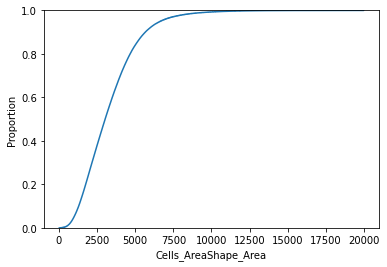

In [31]:
seaborn.ecdfplot(data=df_gt[df_gt["Cells_AreaShape_Area"] < 20000], x="Cells_AreaShape_Area")

<AxesSubplot:xlabel='feat_area_actin', ylabel='Proportion'>

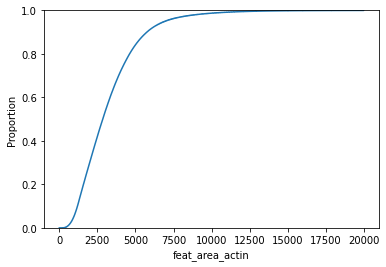

In [32]:
seaborn.ecdfplot(data=df1[df1["feat_area_actin"] < 20000], x="feat_area_actin")

<AxesSubplot:xlabel='Cytoplasm_AreaShape_Area', ylabel='Proportion'>

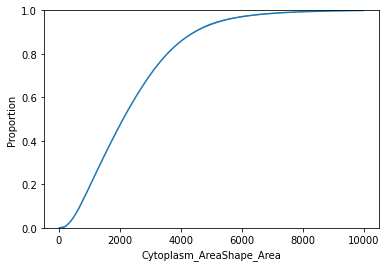

In [35]:
seaborn.ecdfplot(data=df_gt[df_gt["Cytoplasm_AreaShape_Area"] < 10000], x="Cytoplasm_AreaShape_Area")

<AxesSubplot:xlabel='feat_area_tubulin', ylabel='Proportion'>

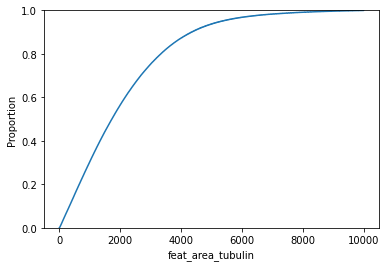

In [37]:
seaborn.ecdfplot(data=df1[df1["feat_area_tubulin"] < 10000], x="feat_area_tubulin")

<AxesSubplot:xlabel='feat_sum_actin', ylabel='Proportion'>

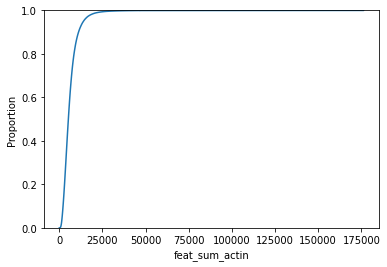

In [42]:
seaborn.ecdfplot(data=df1, x="feat_sum_actin")

<AxesSubplot:xlabel='Cells_Intensity_MaxIntensity_CorrActin', ylabel='Proportion'>

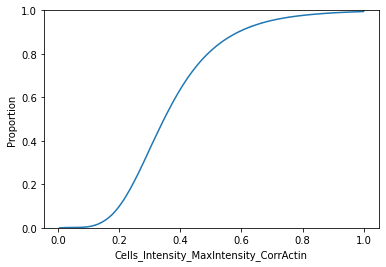

In [39]:
seaborn.ecdfplot(data=df_gt, x="Cells_Intensity_MaxIntensity_CorrActin")